In [1]:
import os
try:
    print(file_path)
except:
    file_path = os.path.abspath('')
    os.chdir(os.path.dirname(file_path))
    print(file_path)

/home/mrzaizai2k/code_Bao/livenessDetection/notebook


In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from src.pyimagesearch.livenessnet import LivenessNet

2024-03-28 23:54:34.387367: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-28 23:54:34.404897: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 23:54:34.581747: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 23:54:34.583308: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 23:54:35.401507: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

# PREPROCESSING DATA

In [3]:
INIT_LR = 1e-5
DECAY_STEPS=10000,
DECAY_RATE=0.9,

EPOCHS = 50
batch_size = 16
img_height = 200
img_width = 200
PATIENCE = 5
seed = 123

liveness_model_path="models/liveness"
data_dir = "dataset"


In [4]:

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3835 files belonging to 2 classes.
Using 3068 files for training.


2024-03-28 23:54:45.376189: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 23:54:45.376431: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 3835 files belonging to 2 classes.
Using 767 files for validation.


In [6]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['fake', 'real']


Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

* Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

* Dataset.prefetch overlaps data preprocessing and model execution while training.
Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.

In [7]:
width = []
height = []
from PIL import Image
import numpy as np

data_path = "dataset"
for dirname in os.listdir(data_path):
    # for category in os.listdir(data_path + '/' + dirname):
    for image in os.listdir(data_path + '/' + dirname + '/' ):
        img = Image.open(data_path + '/' + dirname + '/'  + '/' + image)
        width.append(img.width)
        height.append(img.height)

print('Mean width: {:.4f}'.format(np.mean(width)))
print('Mean Height: {:.4f}'.format(np.mean(height)))

Mean width: 185.1116
Mean Height: 239.3523


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# TRAINING

In [6]:
fill_mode ="constant"
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal', seed=seed),
    tf.keras.layers.RandomRotation(0.15, fill_mode=fill_mode, seed=seed),
    tf.keras.layers.RandomZoom(0.1, fill_mode=fill_mode, seed=seed),
    tf.keras.layers.RandomTranslation(0.1, 0.1, fill_mode=fill_mode, seed=seed),
    tf.keras.layers.RandomBrightness(factor=0.15, seed=seed),
    tf.keras.layers.RandomContrast(factor = 0.15, seed=seed, ),
    # tf.keras.layers.RandomCrop(height, width, seed=seed)
    ])

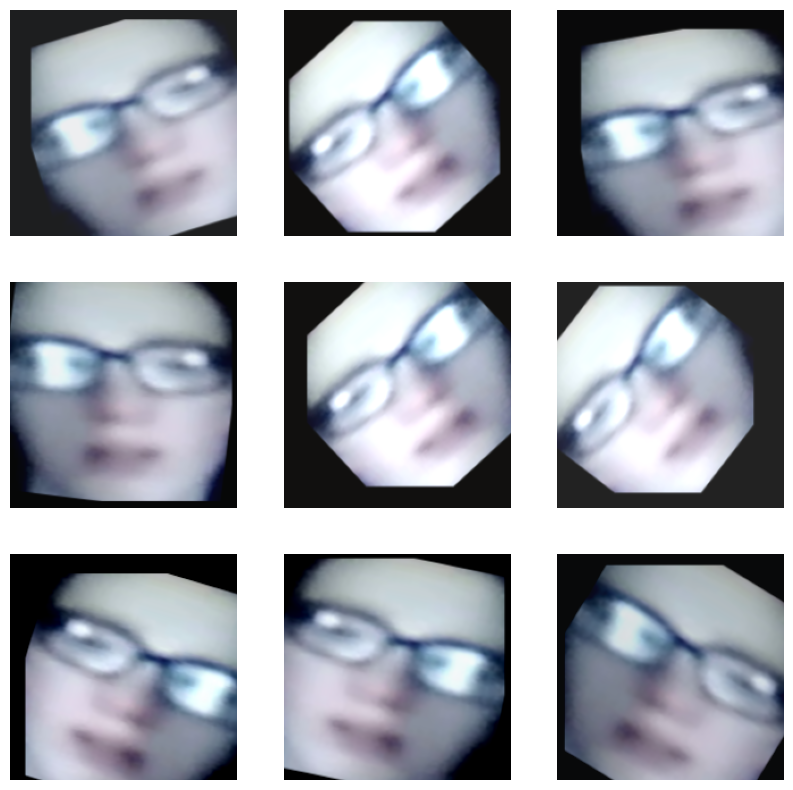

In [7]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [8]:
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input
base_model = tf.keras.applications.EfficientNetV2B0(
                                include_top=False,
                                weights='imagenet',
                                input_tensor=None,
                                input_shape=None,
                                pooling=None,
                            )
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid', name="fc2")
scale_layer = tf.keras.layers.Rescaling(scale=1 / 255)


In [9]:
inputs = tf.keras.Input(shape=(img_width, img_height, 3), name="input_2")
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [10]:

print("[INFO] compiling model...")

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    INIT_LR,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
    staircase=True)

opt = Adam(learning_rate=lr_schedule)

model.summary()


[INFO] compiling model...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 200, 200, 3)       0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None,

 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 fc2 (Dense)                 (None, 1)                 513       
                                                                 
Total params: 7756369 (29.59 MB)
Trainable params: 7695761 (29.36 MB)
Non-trainable params: 60608 (236.75 KB)
_________________________________________________________________


In [11]:

model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy'),
                       tf.keras.metrics.AUC(),
                       tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),])

In [12]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)],

)

Epoch 1/10
192/192 [==============================] - 95s 430ms/step - loss: 0.2905 - accuracy: 0.9061 - auc: 0.9694 - precision: 0.8697 - recall: 0.9481 - val_loss: 0.0508 - val_accuracy: 0.9922 - val_auc: 0.9996 - val_precision: 0.9872 - val_recall: 0.9974
Epoch 2/10
192/192 [==============================] - 83s 433ms/step - loss: 0.0371 - accuracy: 0.9902 - auc: 0.9991 - precision: 0.9899 - recall: 0.9899 - val_loss: 0.0146 - val_accuracy: 0.9948 - val_auc: 1.0000 - val_precision: 0.9923 - val_recall: 0.9974
Epoch 3/10
192/192 [==============================] - 82s 429ms/step - loss: 0.0149 - accuracy: 0.9958 - auc: 0.9999 - precision: 0.9960 - recall: 0.9953 - val_loss: 0.0077 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/10
192/192 [==============================] - 82s 429ms/step - loss: 0.0160 - accuracy: 0.9945 - auc: 0.9998 - precision: 0.9939 - recall: 0.9946 - val_loss: 0.0125 - val_accuracy: 0.9961 - val_auc: 1.0000 - val_pre

# TESTING

In [15]:
face_path = "test_images/3.png"

img = tf.keras.utils.load_img(
    face_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
print("predictions", predictions)
pred = tf.nn.sigmoid(predictions[0])
print("pred", pred)

# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )


1/1 [==============================] - 1s 1s/step
predictions [[0.00497916]]
pred tf.Tensor([0.5012448], shape=(1,), dtype=float32)


# Save models

In [13]:

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open(f'{liveness_model_path}/efficientnet_model.tflite', 'wb') as f:
    f.write(tflite_model)
    print (f"Tflite model saved in")

INFO:tensorflow:Assets written to: /tmp/tmp1u0i6ikm/assets


INFO:tensorflow:Assets written to: /tmp/tmp1u0i6ikm/assets
2024-03-29 00:09:56.719079: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-03-29 00:09:56.719124: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-03-29 00:09:56.719793: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1u0i6ikm
2024-03-29 00:09:56.756741: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-03-29 00:09:56.756777: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmp1u0i6ikm
2024-03-29 00:09:56.872892: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-03-29 00:09:56.915352: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-03-29 00:09:58.021334: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

Tflite model saved in


In [14]:

model.save(f"{liveness_model_path}/efficientnet.h5")
print("\nsaved model h5")

/home/mrzaizai2k/code_Bao/livenessDetection/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



saved model h5


# Plot Training

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(0, len(history.history['accuracy']))

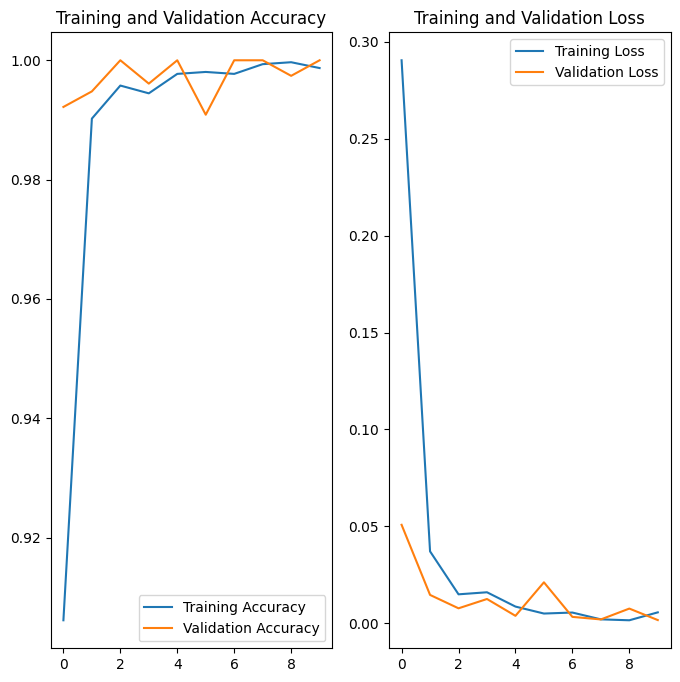

In [17]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
 

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('docs/train.jpg')
plt.show()